In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
sns.set_style("whitegrid")

In [2]:
#Read in cleaned data
#df_train = pd.read_csv('data/cleaned_train_2005.csv')
df_train = pd.read_csv('data/cleaned_train_full_2005.csv')
df_train.head()

,Title,Creator,UsageClass,MaterialType,Genre,CleanedPublisher,CheckoutMonth,CheckoutYear,PreviousYearCheckoutsSum,PreviousYearCheckoutsMean,PreviousYearPublished,PreviousYearPublishedMean,FirstYearCheckouts
0,"American seafood : heritage, culture & cookery...","Seaver, Barton",Physical,BOOK,other,other publisher,1,2018,113,2.670833,1,62.046138,9
1,The runaway pea / Kjartan Poskitt & Alex Willm...,"Poskitt, Kjartan",Physical,BOOK,juvenile,simon & schuster,2,2022,36,1.270833,2,0.000000,167
2,What the cat dragged in / Miranda James.,"James, Miranda",Physical,BOOK,mystery,other publisher,9,2021,487,2.027593,1,0.000000,31
3,R.F.K. : a photographer's journal / Harry Benson.,"Benson, Harry",Physical,BOOK,history,other publisher,11,2008,0,0.000000,1,63.876983,12
4,Ice Drift,Theodore Taylor,Digital,EBOOK,juvenile,harpercollins,11,2013,36,1.322222,2,0.000000,4


In [230]:
df_train.columns

Index(['Title', 'Creator', 'UsageClass', 'MaterialType', 'Genre',
       'CleanedPublisher', 'CheckoutMonth', 'CheckoutYear',
       'PreviousYearCheckoutsSum', 'PreviousYearCheckoutsMean',
       'PreviousYearPublished', 'PreviousYearPublishedMean',
       'FirstYearCheckouts'],
      dtype='object')

## Baseline Model: 

For our baseline model, we predict the number of first year checkouts for a library item as the average of all the first year checkout data. 

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

In [4]:
## Make KFold object to be used on training dataset
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 216)

In [5]:
rmses = np.zeros(5)

for i, (train_index, test_index) in enumerate(kfold.split(df_train, df_train['FirstYearCheckouts'])):
    ## get the kfold training and holdout data
    X_tt = df_train.iloc[train_index]
    X_ho = df_train.iloc[test_index]

    #Get average of the first year checkouts for our train set 
    baseline_pred = np.ones(len(X_ho)) * X_tt['FirstYearCheckouts'].mean() 

    ## Record the rmses
    rmses[i] = root_mean_squared_error(X_ho['FirstYearCheckouts'], baseline_pred)

In [6]:
print(rmses)
print(rmses.mean())

[114.72254652 121.97266529 109.23361391 118.73402191 115.23831321]
115.98023216785975


In [7]:
print('The average number of first year checkouts for the whole training dataset is', df_train['FirstYearCheckouts'].mean())
print('The median number of first year checkouts in our dataset is', np.median(df_train['FirstYearCheckouts']))
print('The minimum and maximum first year checkouts in our dataset are', df_train['FirstYearCheckouts'].min(), \
      'and', df_train['FirstYearCheckouts'].max(), 'respectively')

The average number of first year checkouts for the whole training dataset is 44.87509717142807
The median number of first year checkouts in our dataset is 21.0
The minimum and maximum first year checkouts in our dataset are 1 and 9633 respectively


Our median and average are pretty low compared with the maximum we see; our distribution seems to have a long tail, so we will likely have higher RSMEs. 

## First Modeling Attempt: Linear Regression

For our first model, we will consider linear regression. We will train on all features outside of Title and Creator, and we one-hot encode the categorical variables UsageClass, MaterialType, Genre, CleanedPublisher. Since UsageClass is binary, we will replace this column with a 1 if the item is Physical and 0 if the item is Digital. 

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
#Get list of cateories for columns of one-hot encoding
genre_list = df_train['Genre'].unique().tolist()
material_list = df_train['MaterialType'].unique().tolist()
publisher_list = df_train['CleanedPublisher'].unique().tolist()

# One-hot encoding of 'Genre' variable
df_train[genre_list] = pd.get_dummies(df_train['Genre'])

# One-hot encoding of 'MaterialType' variables
df_train[material_list] = pd.get_dummies(df_train['MaterialType'])

# One-hot encoding of 'CleanedPublisher' variable
df_train[publisher_list] = pd.get_dummies(df_train['CleanedPublisher'])

#One hot encode UsageClass into single column with 1 indicating 'Physical' and 0 indicating 'Digital'
df_train['UsageClass'] = pd.get_dummies(df_train['UsageClass'])['Physical']
#df_train = df_train.drop(columns = ['Genre', 'MaterialType'])
df_train = df_train.drop(columns = ['Genre', 'MaterialType', 'CleanedPublisher'])

In [10]:
df_train.columns

Index(['Title', 'Creator', 'UsageClass', 'CheckoutMonth', 'CheckoutYear',
       'PreviousYearCheckoutsSum', 'PreviousYearCheckoutsMean',
       'PreviousYearPublished', 'PreviousYearPublishedMean',
       'FirstYearCheckouts', 'other', 'juvenile', 'mystery', 'history',
       'nonfiction', 'fiction', 'romance', 'fantasy/sci-fi', 'biography',
       'young adult', 'horror/thriller', 'BOOK', 'EBOOK', 'AUDIOBOOK',
       'SOUNDDISC', 'OTHER', 'VIDEODISC', 'other publisher',
       'simon & schuster', 'harpercollins', 'penguin random house', 'hachette',
       'blackstone', 'harlequin', 'macmillan', 'scholastic',
       'lightning source', 'recorded books', 'brilliance'],
      dtype='object')

In [11]:
# Features we want to train our linear regression on
features =['UsageClass', 'CheckoutMonth', 'CheckoutYear',
       'PreviousYearCheckoutsSum', 'PreviousYearCheckoutsMean',
       'PreviousYearPublished', 'PreviousYearPublishedMean'
       , 'other', 'juvenile', 'mystery', 'history',
       'nonfiction', 'fiction', 'romance', 'fantasy/sci-fi', 'biography',
       'young adult', 'horror/thriller', 'BOOK', 'EBOOK', 'AUDIOBOOK',
       'SOUNDDISC', 'OTHER', 'VIDEODISC', 'other publisher',
       'simon & schuster', 'harpercollins', 'penguin random house', 'hachette',
       'blackstone', 'harlequin', 'macmillan', 'scholastic',
       'lightning source', 'recorded books', 'brilliance']

In [240]:
# Kfold split
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 216)

In [241]:
# Array to store rmse
rmse = np.zeros(5)

# Initialize LinearRegression Model
lr = LinearRegression()

for i, (train_index, test_index) in enumerate(kfold.split(df_train, df_train['FirstYearCheckouts'])):

    ## get the kfold training and holdout data
    X_tt = df_train.iloc[train_index]
    X_ho = df_train.iloc[test_index]

    ## Fit model
    lr.fit(X_tt[features], X_tt['FirstYearCheckouts'])

    ## Generate predictions on the holdout set
    lr_preds = lr.predict(X_ho[features])

    ## Record the rmses
    rmses[i] = root_mean_squared_error(X_ho['FirstYearCheckouts'], lr_preds)

In [242]:
print(rmses)
print(rmses.mean())

[109.98766426 117.18175179 104.24685806 114.22175667 109.89098079]
111.10580231523207


## Adding Regularization: 

We add lasso regularization to our model to see what features are most important. We first run the regularizaiton with alpha = 0.1. 

In [243]:
from sklearn.linear_model import Lasso

In [244]:
# Kfold split
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 216)

# Array to store rmse
rmse = np.zeros(5)

#Initialize Lasso regression model
lasso = Lasso(alpha=0.1)  

for i, (train_index, test_index) in enumerate(kfold.split(df_train, df_train['FirstYearCheckouts'])):

    ## get the kfold training and holdout data
    X_tt = df_train.iloc[train_index]
    X_ho = df_train.iloc[test_index]

    ## Fit model
    lasso.fit(X_tt[features], X_tt['FirstYearCheckouts'])


    ## Generate predictions on the holdout set
    lasso_preds = lasso.predict(X_ho[features])

    ## Record the rmses
    rmses[i] = root_mean_squared_error(X_ho['FirstYearCheckouts'], lasso_preds)

In [245]:
print(rmses)
print(rmses.mean())

[110.01183039 117.20027996 104.26801716 114.2452093  109.94932836]
111.13493303349594


We see that this behaves very similarly to linear regression without regularization. We now search through different alpha values to see which values gives the best model and what features are most important. 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
n =len(features)

lasso_coefs = np.empty((len(alpha),n))
rmses = np.empty(len(alpha))

## for each alpha value
for i in range(len(alpha)):
    print(alpha[i])
    print()
    
    ## set up the lasso pipeline
    lasso_pipe = Pipeline([('scale',StandardScaler()),
                              ('lasso', Lasso(alpha=alpha[i]))
                          ])
    
    ## fit the lasso
    lasso_pipe.fit(df_train[features], df_train['FirstYearCheckouts'])

    ## predict 
    pred = lasso_pipe.predict(df_train[features])
    rmses[i] = root_mean_squared_error(pred, df_train['FirstYearCheckouts'])


    # record the coefficients
    lasso_coefs[i,:] = lasso_pipe['lasso'].coef_

1e-05



In [ ]:
print("Lasso Coefficients")
pd.set_option('display.max_columns', None)
pd.DataFrame(np.round(lasso_coefs,8),
            columns = features,
            index = ["alpha=" + str(a) for a in alpha])

Lasso Coefficients


,UsageClass,CheckoutMonth,CheckoutYear,PreviousYearCheckoutsSum,PreviousYearCheckoutsMean,PreviousYearPublished,PreviousYearPublishedMean,other,juvenile,mystery,history,nonfiction,fiction,romance,fantasy/sci-fi,biography,young adult,horror/thriller,BOOK,EBOOK,AUDIOBOOK,SOUNDDISC,OTHER,VIDEODISC,other publisher,simon & schuster,harpercollins,penguin random house,hachette,blackstone,harlequin,macmillan,scholastic,lightning source,recorded books,brilliance
alpha=1e-05,1.664975,-0.964015,2.154109,10.139801,25.859853,-5.236976,-0.107529,1.812815,1.265832,3.098828,-0.885583,3.441402,-4.046213,1.388172,1.467246,-0.232567,1.666957,-2.078180,1.876726,9.303623,-4.319153,-1.559242,3.162130,0.666570,-2.300159,-3.481724,-0.521887,-0.105125,1.384022,-0.367599,0.848916,-3.964979,2.592150,-1.943754,-0.736035,2.041423
alpha=0.0001,1.664058,-0.963929,2.154056,10.139687,25.859816,-5.236870,-0.107438,1.782882,1.237379,3.058264,-0.912019,3.417605,-4.093303,1.360306,1.433842,-0.279802,1.641160,-2.099282,1.829955,9.231508,-4.386252,-1.577137,3.123854,0.662750,-2.285572,-3.472933,-0.506179,-0.096145,1.411146,-0.356666,0.867538,-3.914986,2.627753,-1.928767,-0.723138,2.060568
alpha=0.001,1.654891,-0.963070,2.153522,10.138550,25.859449,-5.235815,-0.106528,1.483553,0.952853,2.652626,-1.176379,3.179631,-4.564208,1.081643,1.099807,-0.752154,1.383193,-2.310301,1.362250,8.510351,-5.057241,-1.756090,2.741104,0.624550,-2.139704,-3.385022,-0.349091,-0.006343,1.682389,-0.247339,1.053758,-3.415061,2.983781,-1.778897,-0.594171,2.252015
alpha=0.01,1.993023,-0.955239,2.141577,10.127746,25.853330,-5.222673,-0.097726,0.482386,0.000000,1.297713,-2.050391,2.383210,-6.125209,0.147401,-0.000681,-2.315385,0.520149,-3.007046,-0.000000,6.015137,-7.012715,-2.315806,1.413071,0.486074,-1.806879,-3.180415,-0.000000,0.182016,2.283397,-0.000000,1.463387,-2.285995,3.769654,-1.436665,-0.298573,2.672745
alpha=0.1,4.257006,-0.875235,2.038845,10.016275,25.793761,-5.100807,-0.008933,0.447162,0.000000,1.265386,-1.928238,2.334171,-5.977353,0.075079,-0.000000,-2.119430,0.444656,-2.917202,-0.000000,3.465494,-6.910069,-2.518260,0.000000,0.263009,-1.727428,-3.087556,-0.000000,0.078069,2.159719,-0.000000,1.331534,-2.257082,3.585012,-1.350459,-0.233581,2.544852
alpha=1,2.692603,-0.030059,1.496581,8.966051,25.281457,-4.032972,-0.000000,0.342630,0.000000,1.208996,-0.483923,1.992429,-4.029570,0.000000,-0.000000,-0.000000,0.000000,-1.810563,0.000000,3.639780,-5.010462,-1.721461,0.000000,0.000000,-0.628492,-2.073609,-0.000000,0.000000,1.123811,-0.000000,0.150641,-1.865294,2.097519,-0.233642,-0.000000,1.376000
alpha=10,0.000000,-0.000000,0.000000,0.623988,18.233488,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000
alpha=100,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000
alpha=1000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000


PreviousYearCheckoutsMean is the feature with the coefficient of highest magnitude, with PreviousYearCheckoutSum and PreviousYearPublished also of larger magnitude. It is interesting to note that PreviousYearPublished has negative coefficients so that authors with books written in the last year have fewer checkouts.   UsageClass and CheckoutYear have coefficients of medium magntiude. In the Genre category, most of the coefficients are smaller, though those of nonfiction and fiction are of medium magnitude. Of the MaterialType categories, EBOOK and AUDIOBOOK are the most important with a positive coefficient for EBOOK but a negative one for AUDIOBOOKS. There are a few publishers with coefficients that are of slightly larger magnitude compared with the others, though most of the coefficients still stay on the smaller side.  We note that for large alpha values, none of the features are good indicators of FirstYearCheckout as all of the features zero out. 

In [ ]:
print('RMSE by alpha: ')
for i in range(len(alpha)):
    print('Alpha', alpha[i], ':', rmses[i])

RMSE by alpha: 
Alpha 1e-05 : 111.17017748421029
Alpha 0.0001 : 111.1701774859389
Alpha 0.001 : 111.17017765880108
Alpha 0.01 : 111.17020068991974
Alpha 0.1 : 111.1721580317754
Alpha 1 : 111.29169576805603
Alpha 10 : 112.92470439838675
Alpha 100 : 116.05858206189905
Alpha 1000 : 116.05858206189905


We see that all of the alpha values give similar RMSEs compared with normal linear regression. 

## Additional Models: 

### Random Forest:

We now try a Random Forest, which should allow for non-linearity and will hopefully perform better as we do not expect our data to behave linearly based on earlier data exploration. It also gives us indicators of feature importance

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


df_tt, df_ho = train_test_split(df_train, test_size=0.2,\
                                      shuffle=True, random_state=216)

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(df_tt[features], df_tt['FirstYearCheckouts'])

# Make predictions on the test set
y_pred = rf_model.predict(df_ho[features])

# Evaluate the model
rmse = root_mean_squared_error(df_ho['FirstYearCheckouts'], y_pred)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 103.95280888503329


In [13]:
max_depth = max(estimator.get_depth() for estimator in rf_model.estimators_)

print('Max depth in random forest model', max_depth) 

Max depth in random forest model 66


In [14]:
pd.DataFrame({'feature_importance_score':rf_model.feature_importances_},
                 index=features).sort_values('feature_importance_score',
                                                ascending=False)

,feature_importance_score
PreviousYearCheckoutsMean,0.249024
PreviousYearCheckoutsSum,0.195543
CheckoutYear,0.106240
CheckoutMonth,0.093520
PreviousYearPublishedMean,0.091144
PreviousYearPublished,0.033339
EBOOK,0.018649
mystery,0.016624
fiction,0.016502
biography,0.016128


This improves are error by about 10 checkouts, which is not a huge improvement, but still noticable. We also see that the PreviousYearCheckoutsMean and PreviousYearCheckoutsSum are the features of primary importance with little importance on the categorical features of Genre, Publisher, MaterialType, and UsageClass. 

We can do a search through parameter space on the max depth and number of trees to improve our model: 

In [ ]:
from sklearn.model_selection import GridSearchCV

In [64]:
max_depths = range(1,11)
n_trees = [100, 500]


## This will also take about two minutes
grid_cv = GridSearchCV(RandomForestRegressor(), # first put the model object here
                          param_grid = {'max_depth':max_depths, # place the grid values for max_depth and
                                        'n_estimators':n_trees}, # and n_estimators here
                          scoring = 'neg_root_mean_squared_error', # put the metric we are trying to optimize here as a string, "accuracy"
                          cv = 5) # put the number of cv splits here

## you fit it just like a model
grid_cv.fit(df_train[features], df_train['FirstYearCheckouts'])

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 11), 'n_estimators': [100, 500]},
             scoring='neg_root_mean_squared_error')

In [65]:
grid_cv.best_params_

{'max_depth': 10, 'n_estimators': 500}

In [69]:
grid_cv.best_score_

-104.01956318839453

In [67]:
grid_cv.best_estimator_

RandomForestRegressor(max_depth=10, n_estimators=500)

### Extra Trees:

We also consider ExtraTrees to see if the not-pure greedy split helps our model. 

In [58]:
from sklearn.ensemble import ExtraTreesRegressor

In [59]:
df_tt, df_ho = train_test_split(df_train, test_size=0.2,\
                                      shuffle=True, random_state=216)

# Create a Random Forest Regressor model
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Train the model
et_model.fit(df_tt[features], df_tt['FirstYearCheckouts'])

# Make predictions on the test set
y_pred = et_model.predict(df_ho[features])

# Evaluate the model
rmse = root_mean_squared_error(df_ho['FirstYearCheckouts'], y_pred)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 108.41431332555273


We see that ExtraTrees does not improve upon our Random Forest model. 

### k-Nearest Neighbor:

We now use KNN Regressor to model our problem and compare it with the RandomForest. 

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df_tt, df_ho = train_test_split(df_train, test_size=0.2,\
                                      shuffle=True, random_state=216)

neigh = Pipeline([ ( 'scale', StandardScaler()), ('knn', KNeighborsRegressor())])

neigh.fit(df_tt[features], df_tt['FirstYearCheckouts'])

# Make predictions on the test set
y_pred = neigh.predict(df_ho[features])

# Evaluate the model
rmse = root_mean_squared_error(df_ho['FirstYearCheckouts'], y_pred)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 109.43480298078369


This is still a slight improvement over the baseline model, but does worse than the RandomForest model. We now do a comparison of the RMSE from different numbers of neighbors to see what performs best; we only run this on a smaller subset of features for computational convenience. 

5
10
15
20
25
30
35
40
45
50


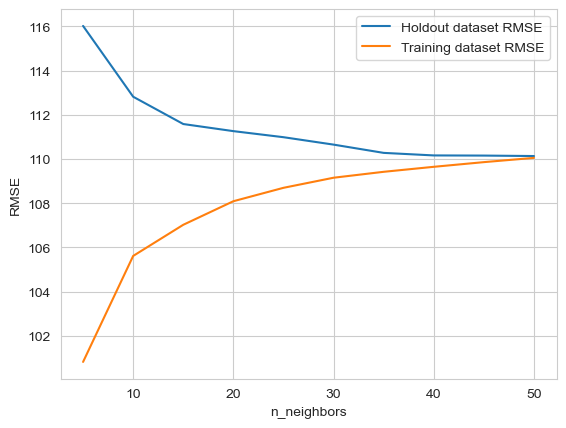

In [20]:
feature_prev = ['PreviousYearCheckoutsSum', 'PreviousYearCheckoutsMean']

neighbors = np.arange(5, 55, 5) 
train_rmse = np.empty(len(neighbors)) 
test_rmse = np.empty(len(neighbors)) 
  
# Loop over K values 
for i, k in enumerate(neighbors): 
    print(k)
    
    knn = Pipeline([ ( 'scale', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=k))])
    #knn.fit(df_tt[new_features], df_tt['FirstYearCheckouts']) 
    knn.fit(df_tt[feature_prev], df_tt['FirstYearCheckouts']) 
      
    # Compute training and test data accuracy 
    train_rmse[i] = root_mean_squared_error(knn.predict(df_tt[feature_prev]), df_tt['FirstYearCheckouts']) 
    test_rmse[i] = root_mean_squared_error(knn.predict(df_ho[feature_prev]), df_ho['FirstYearCheckouts']) 
  
  
# Generate plot 
plt.plot(neighbors, test_rmse, label = 'Holdout dataset RMSE') 
plt.plot(neighbors, train_rmse, label = 'Training dataset RMSE') 
  
plt.legend() 
plt.xlabel('n_neighbors') 
plt.ylabel('RMSE') 
plt.show() 

Overall, kNN doesn't seem like a great fit for our situation, as the RMSE on the holdout data is fairly high. 

### XGBoost: 

We also try XGBoost Regressor as another possible model that can deal better with nonlinearity. 

In [22]:
#!pip install xgboost
from xgboost import XGBRegressor, plot_importance

In [23]:
# Split data into training and hold out set
df_tt, df_ho = train_test_split(df_train, test_size=0.2,\
                                      shuffle=True, random_state=216)

# Initialize model
xgb_model = XGBRegressor()

# Fit model
xgb_model.fit(df_tt[features], df_tt['FirstYearCheckouts'])

# Make predictions
pred = xgb_model.predict(df_ho[features])

rmse = root_mean_squared_error(pred, df_ho['FirstYearCheckouts'])

print('RMSE for XGBoost Regressor:', rmse)



RMSE for XGBoost Regressor: 101.82688008798233


In [ ]:
ax = plot_importance(xgb_model, importance_type='weight')

We are also able to look at feature importance in XGBoost. There are multiple importance models (gain, weight, cover) for XGBoost which yield different feature importances (see https://medium.com/@emilykmarsh/xgboost-feature-importance-233ee27c33a4 for more details) without a clear choice of which is "correct". Thus as an alternatvie, we use SHAP importance values, which use cooperative game theory to quantify how important each input variable is to a model for making predictions, to determine feature importance instead of the built in feature importance of XGBoost. Below we see that the top features aligns with those found in the Random Forest. 

In [31]:
import shap

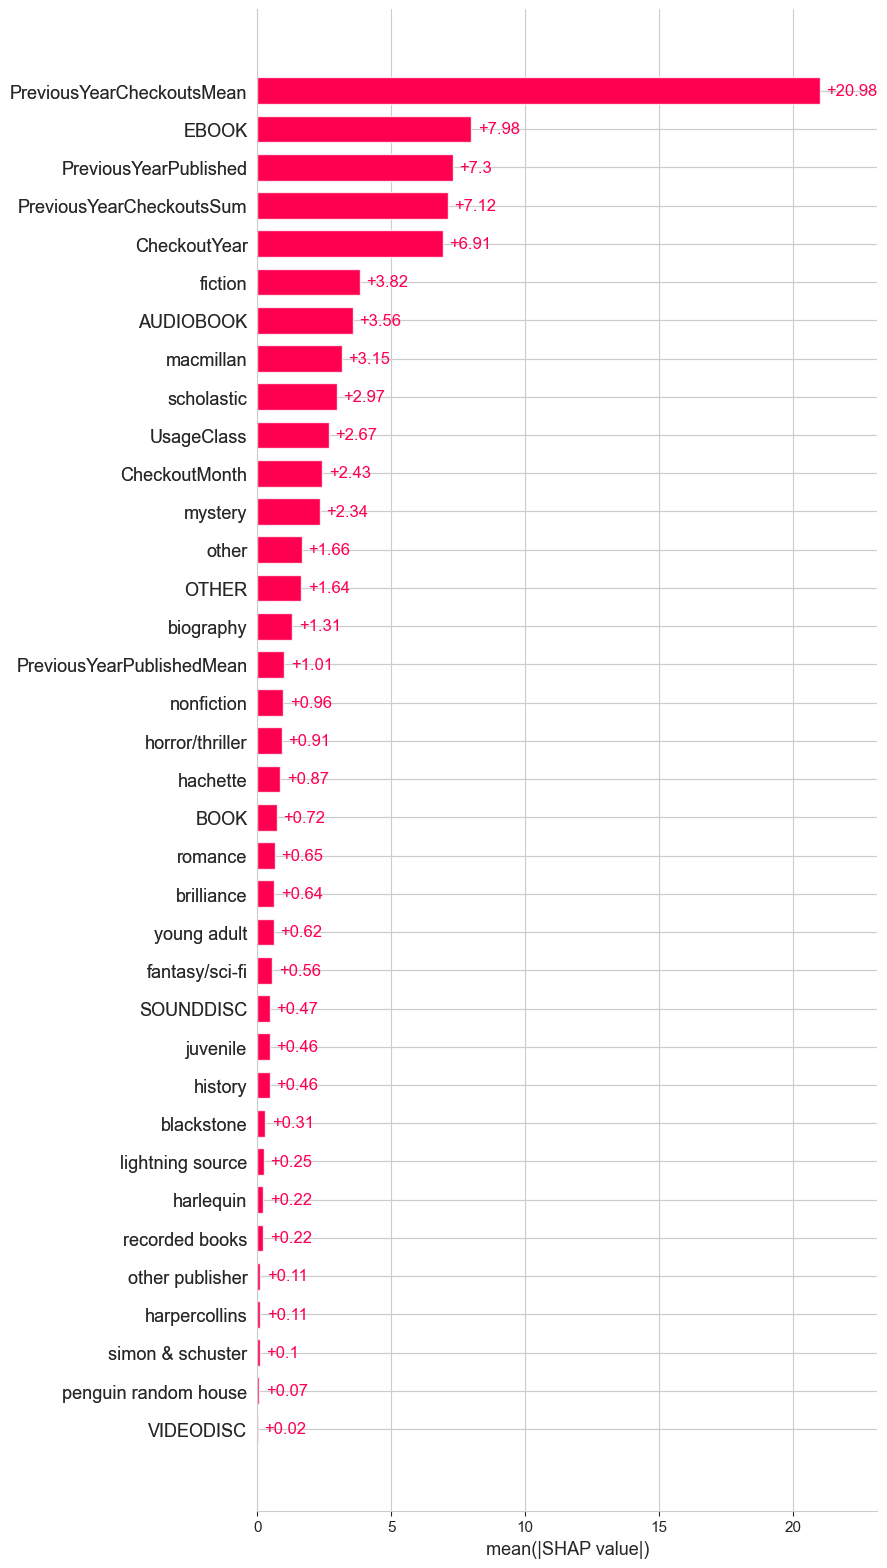

In [32]:
X = df_ho[features]
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X)

shap.plots.bar(shap_values, max_display=X.shape[1])

We can also run it on the top two importance features found by the Random Forest, but we see below that the performance decreases and so we will use all features to train the model going forward. 

In [83]:
features_prev = ['PreviousYearCheckoutsSum', 'PreviousYearCheckoutsMean']

xgb = XGBRegressor()

# Fit model
xgb.fit(df_tt[features_prev], df_tt['FirstYearCheckouts'])

# Make predictions
pred = xgb.predict(df_ho[features_prev])

rmse = root_mean_squared_error(pred, df_ho['FirstYearCheckouts'])

print('RMSE for XGBoost Regressor:', rmse)


RMSE for XGBoost Regressor: 109.96556721042539


In [47]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 150), 
    'min_child_weight': stats.randint(1, 10), 
    'colsample_bytree': stats.uniform(0,1), 
     'gamma': stats.randint(1,9),
}

# Create the XGBoost model object
xgb_model = XGBRegressor()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, 
                                   cv=5, scoring='neg_root_mean_squared_error', error_score='raise')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(df_train[features], df_train['FirstYearCheckouts'])

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'colsample_bytree': 0.6824510280396993, 'gamma': 1, 'learning_rate': 0.07200087026276446, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 88, 'subsample': 0.7815461804461934}
Best score:  -102.31745366668248


### Neural Network: 

We also try a small NN to see if it can capture any additional structure. 

In [52]:
from sklearn.neural_network import MLPRegressor

In [54]:
nn = MLPRegressor(
    activation='relu',
    hidden_layer_sizes=(100,),
    alpha=0.001,
    random_state=20,
    early_stopping=False
)

nn.fit(df_tt[features], df_tt['FirstYearCheckouts'])

pred = nn.predict(df_ho[features])

rmse = root_mean_squared_error(pred, df_ho['FirstYearCheckouts'])

print('RMSE for NN with 1 hidden layers each with 100 neurons:', rmse)


RMSE for NN with 1 hidden layers each with 100 neurons: 106.00505114384612


We note that this does not improve our estimate compared with RandomForest and XgBoost Regressor. It is possible with tuning we could improve this importance, but that is beyond the scope of this project. 

## Final Model Choice: 

From the above analysis, we see that RandomForest and XGBoost perform similarly with XGBoost performing slighly better with a faster training time. Thus we select XGBoost as our final model and tune our hyperparameters before running our model on our testing dataset. For our hyperparameter tuning, we use Bayesian optimization, which uses past results to find the optimal set of hyperparameters and thus is more efficient than GridCV and RandomSearchCV.


In [33]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [44]:
space={'max_depth': hp.quniform("max_depth", 3, 6, 1),
        'gamma': hp.uniform('gamma', 1,9),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'n_estimators': hp.quniform("n_estimators", 50, 150, 5)
    }


In [53]:
df_tt, df_ho = train_test_split(df_train, test_size=0.2,\
                                      shuffle=True)

#Objective function for Bayesian hyperparameter tuning
def objective(space):
    clf=XGBRegressor(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    min_child_weight=space['min_child_weight'],
                    colsample_bytree=space['colsample_bytree'], 
                    subsample = space['subsample'], learning_rate = space['learning_rate'])
    
    clf.fit(df_tt[features], df_tt['FirstYearCheckouts'])
    

    pred = clf.predict(df_ho[features])
    rmse = root_mean_squared_error(pred, df_ho['FirstYearCheckouts'])
    #print ("SCORE:",rmse)
    return {'loss': rmse, 'status': STATUS_OK }


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)


100%|██████████| 100/100 [03:09<00:00,  1.89s/trial, best loss: 110.3541093978368]


In [54]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)
print("Lowest loss:", min(trials.losses()))

The best hyperparameters are :  

{'colsample_bytree': 0.9253800499867285, 'gamma': 7.8329219056675035, 'learning_rate': 0.09994531847457151, 'max_depth': 6.0, 'min_child_weight': 7.0, 'n_estimators': 150.0, 'subsample': 0.9128394511766976}
Lowest loss: 110.3541093978368


In [71]:
# Load in testing dataset
df_test = pd.read_csv('data/cleaned_test_full_2005.csv')

# Run baseline model on testing dataset:
#Get average of the first year checkouts for our train set 
baseline_pred = np.ones(len(df_test)) * df_train['FirstYearCheckouts'].mean()

## Record the rmses
rmse_baseline = root_mean_squared_error(df_test['FirstYearCheckouts'], baseline_pred)



In [72]:
#Get list of cateories for columns of one-hot encoding
genre_list = df_test['Genre'].unique().tolist()
material_list = df_test['MaterialType'].unique().tolist()
publisher_list = df_test['CleanedPublisher'].unique().tolist()

# One-hot encoding of 'Genre' variable
df_test[genre_list] = pd.get_dummies(df_test['Genre'])

# One-hot encoding of 'MaterialType' variables
df_test[material_list] = pd.get_dummies(df_test['MaterialType'])

# One-hot encoding of 'CleanedPublisher' variable
df_test[publisher_list] = pd.get_dummies(df_test['CleanedPublisher'])

#One hot encode UsageClass into single column with 1 indicating 'Physical' and 0 indicating 'Digital'
df_test['UsageClass'] = pd.get_dummies(df_test['UsageClass'])['Physical']
#df_train = df_train.drop(columns = ['Genre', 'MaterialType'])
df_test = df_test.drop(columns = ['Genre', 'MaterialType', 'CleanedPublisher'])

In [73]:
# Initialize final model with hyperparameters from tuning above
best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
xgb_model = XGBRegressor(**best_hyperparams)


# Fit model 
xgb_model.fit(df_train[features], df_train['FirstYearCheckouts'])

# Make predictions
pred = xgb_model.predict(df_test[features])

rmse_xgb = root_mean_squared_error(pred, df_test['FirstYearCheckouts'])

In [74]:
print('Testing RMSE for Baseline:', rmse_baseline)
print('Testing RMSE for XGBoost Regressor:', rmse_xgb)

Testing RMSE for Baseline: 119.15157867753868
Testing RMSE for XGBoost Regressor: 115.64865915344903


## Predicting log(FirstYearCheckouts):

We could also look at predicting the order of magnitude of the first year checkouts, and consider instead predicting on the log of the FirstYearCheckouts with all the same models as above besides k-Nearest Neighbor and the Neural Network as these did not provide much improvement. 

In [75]:
df_train['logFYC'] = np.log10(df_train['FirstYearCheckouts'])

#### Baseline:

In [76]:
## Make KFold object to be used on training dataset
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 216)


rmses = np.zeros(5)

for i, (train_index, test_index) in enumerate(kfold.split(df_train, df_train['logFYC'])):
    ## get the kfold training and holdout data
    X_tt = df_train.iloc[train_index]
    X_ho = df_train.iloc[test_index]

    #Get average of the first year checkouts for our train set 
    baseline_pred = np.ones(len(X_ho)) * X_tt['logFYC'].mean() 

    ## Record the rmses
    rmses[i] = root_mean_squared_error(X_ho['logFYC'], baseline_pred)

In [77]:
print(rmses)
print(rmses.mean())

[0.54403594 0.54392708 0.54377702 0.5427933  0.54642483]
0.5441916335734021


In [78]:
10**0.54

3.4673685045253166

As the RMSE is in log-space it behaves like a multipicative factor.  Thus, the model's predictions are, on average, about 3.47 times away from the actual values in the original space, providing a measure of multiplicative error rather than absolute error.

In [79]:
print('The average number of log first year checkouts for the whole dataset is', df_train['logFYC'].mean())
print('The minimum and maximum log first year checkouts in our dataset are', df_train['logFYC'].min(), \
      'and', df_train['logFYC'].max(), 'respectively')

The average number of log first year checkouts for the whole dataset is 1.2983440300851525
The minimum and maximum log first year checkouts in our dataset are 0.0 and 3.983761560286165 respectively


#### Linear Model: 

In [80]:
# Array to store rmse
rmses = np.zeros(5)

# Initialize LinearRegression Model
lr = LinearRegression()

for i, (train_index, test_index) in enumerate(kfold.split(df_train, df_train['logFYC'])):

    ## get the kfold training and holdout data
    X_tt = df_train.iloc[train_index]
    X_ho = df_train.iloc[test_index]

    ## Fit model
    lr.fit(X_tt[features], X_tt['logFYC'])

    ## Generate predictions on the holdout set
    lr_preds = lr.predict(X_ho[features])

    ## Record the rmses
    rmses[i] = root_mean_squared_error(X_ho['logFYC'], lr_preds)

In [81]:
print(rmses)
print(rmses.mean())

[0.49952901 0.49982952 0.49544793 0.49652082 0.50059854]
0.49838516534916044


#### Random Forest Model:

In [82]:
df_train.columns

Index(['Title', 'Creator', 'UsageClass', 'CheckoutMonth', 'CheckoutYear',
       'PreviousYearCheckoutsSum', 'PreviousYearCheckoutsMean',
       'PreviousYearPublished', 'PreviousYearPublishedMean',
       'FirstYearCheckouts', 'other', 'juvenile', 'mystery', 'history',
       'nonfiction', 'fiction', 'romance', 'fantasy/sci-fi', 'biography',
       'young adult', 'horror/thriller', 'BOOK', 'EBOOK', 'AUDIOBOOK',
       'SOUNDDISC', 'OTHER', 'VIDEODISC', 'other publisher',
       'simon & schuster', 'harpercollins', 'penguin random house', 'hachette',
       'blackstone', 'harlequin', 'macmillan', 'scholastic',
       'lightning source', 'recorded books', 'brilliance', 'logFYC'],
      dtype='object')

In [83]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


df_tt, df_ho = train_test_split(df_train, test_size=0.2,\
                                      shuffle=True, random_state=216)

# Create a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(df_tt[features], df_tt['logFYC'])

# Make predictions on the test set
y_pred_log = model.predict(df_ho[features])
y_pred =10**(y_pred_log)

# Evaluate the model
rmse_log = root_mean_squared_error(df_ho['logFYC'], y_pred_log)
rmse = root_mean_squared_error(df_ho['FirstYearCheckouts'], y_pred)

print("Root Mean Squared Error:", rmse_log)
print(rmse)

Root Mean Squared Error: 0.40904772203186623
104.12532718221831


In [84]:
10**(0.4)

2.51188643150958

#### XG Boost Regressor Model: 

In [85]:
# Split data into training and hold out set
df_tt, df_ho = train_test_split(df_train, test_size=0.2,\
                                      shuffle=True, random_state=216)

# Initialize model
xgb = XGBRegressor()

# Fit model
xgb.fit(df_tt[features], df_tt['logFYC'])

# Make predictions
pred = xgb.predict(df_ho[features])

rmse = root_mean_squared_error(pred, df_ho['logFYC'])

print('RMSE for XGBoost Regressor:', rmse)



RMSE for XGBoost Regressor: 0.4020223885124308


Again XGBoost slighly outperforms Random Forest and we use it as our final model. We again tune our hyperparameters: 

In [86]:
space={'max_depth': hp.quniform("max_depth", 3, 6, 1),
        'gamma': hp.uniform('gamma', 1,9),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'n_estimators': hp.quniform("n_estimators", 50, 150, 5)
    }

In [87]:
df_tt, df_ho = train_test_split(df_train, test_size=0.2,\
                                      shuffle=True)

#Objective function for Bayesian hyperparameter tuning
def objective(space):
    clf=XGBRegressor(
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    min_child_weight=space['min_child_weight'],
                    colsample_bytree=space['colsample_bytree'], 
                    subsample = space['subsample'], learning_rate = space['learning_rate'])
    
    clf.fit(df_tt[features], df_tt['logFYC'])
    

    pred = clf.predict(df_ho[features])
    rmse = root_mean_squared_error(pred, df_ho['logFYC'])
    #print ("SCORE:",rmse)
    return {'loss': rmse, 'status': STATUS_OK }


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)


100%|██████████| 100/100 [02:33<00:00,  1.54s/trial, best loss: 0.4075977172017397]


In [88]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)
print("Lowest loss:", min(trials.losses()))

The best hyperparameters are :  

{'colsample_bytree': 0.7858625181669104, 'gamma': 1.115787971936992, 'learning_rate': 0.09958501194716424, 'max_depth': 6.0, 'min_child_weight': 10.0, 'n_estimators': 125.0, 'subsample': 0.6909809302556361}
Lowest loss: 0.4075977172017397


In [90]:
# Load in testing dataset
df_test['logFYC'] = np.log10(df_test['FirstYearCheckouts'])

# Run baseline model on testing dataset:
#Get average of the first year checkouts for our train set 
baseline_pred = np.ones(len(df_test)) * df_train['logFYC'].mean()

## Record the rmses
rmse_baseline = root_mean_squared_error(df_test['logFYC'], baseline_pred)

# Initialize final model with hyperparameters from tuning above
# Initialize final model with hyperparameters from tuning above
best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
xgb_model = XGBRegressor(**best_hyperparams)

# Fit model 
xgb_model.fit(df_train[features], df_train['logFYC'])

# Make predictions
pred = xgb_model.predict(df_test[features])

rmse_xgb = root_mean_squared_error(pred, df_test['logFYC'])


In [91]:
print('Testing RMSE for Baseline:', rmse_baseline)
print('Testing RMSE for XGBoost Regressor:', rmse_xgb)

Testing RMSE for Baseline: 0.5412616788205589
Testing RMSE for XGBoost Regressor: 0.5343519023933915
